# DAT 402 Project 1

Formula One (F1) is the premier motorsport, Formula standing for the requirements needed to construct a fast car, and One representing how it is the top of the motorsport world. We will look into the coveted **podium** of F1, a spot reserved for only the top 3 racers in a Grand Prix.

In [47]:
%pwd
name = 'Manuelito Bagasina'
Project1 = "Formula1"
Date = "October 17, 2024"

# Terms
1. Constructor: The team that designs, builds, and enters the car in Formula 1 races. Examples would be Ferrari, Mercedes, and Red Bull Racing.
2. Podium: The top three finishing positions in a race. Drivers who finish first, second, or third.
3. Grid: The starting order of cars for a race, determined by qualifying sessions.
4. Grand Prix: The name given to each individual race in the Formula 1 World Championship.
5. Lap: One complete circuit of the race track.
6. Fastest Lap: The quickest time set by any driver to complete a single lap during the race.
7. Circuit: The race track where a Grand Prix is held.
8. Qualifying: The session(s) before the race where drivers compete for the best lap time to determine their starting position on the grid.
9. Season: The annual series of Grand Prix races that make up the Formula 1 World Championship.
10. Driver's Championship: The overall title awarded to the driver who accumulate the most points over a season. They gain points by winning races.
11. Constructor's Championship: The overall title awarded to the constructor who accumulate the most points over a season.They gain points by having their drivers(2 usually) win races.

## Goal
The goal of this project is to predict podium finishes in F1. This category was chosen because it's a straightforward and binary category, either you get a podium or not. By leveraging historical F1 data from 1950 to 2020, we'll explore various features that might influence a driver's chances of achieving a podium finish. Through this analysis, we hope to gain deeper insights into the factors that contribute to success in Formula 1 racing.

# Data Loading

In [48]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import difflib
import warnings
warnings.simplefilter("ignore")

# Originally I wanted to make sure that names of drivers and constructors were standardized, but the dataset already cleaned that for me
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [49]:
# Load the datasets
# Many placeholder values use '\N', will need to replace this in data cleaning
races = pd.read_csv('races.csv', na_values='\\N')
results = pd.read_csv('results.csv', na_values='\\N')
drivers = pd.read_csv('drivers.csv', na_values='\\N')
constructors = pd.read_csv('constructors.csv', na_values='\\N')

## Formula 1 World Championship (1950 - 2024)


*   Dataset Name: "Formula 1 World Championship (1950 - 2024)"
*   [Source](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)
*   Target variable: podium_finish
*   This has both categorical and numerical values



> The dataset consists of all information on the Formula 1 races, drivers, constructors, and results from 1950 till the latest 2024 season.








In [50]:
# Basic information about the datasets
print("Races dataset shape:", races.shape)
print("\nRaces dataset columns:", races.columns.tolist())

Races dataset shape: (1125, 18)

Races dataset columns: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']


In [51]:
print("\nResults dataset shape:", results.shape)
print("\nResults dataset columns:", results.columns.tolist())


Results dataset shape: (26519, 18)

Results dataset columns: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']


In [52]:
print("Races dataset shape:", drivers.shape)
print("\nRaces dataset columns:", drivers.columns.tolist())

Races dataset shape: (859, 9)

Races dataset columns: ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']


In [53]:
print("Constructors dataset shape:", constructors.shape)
print("\nConstructors dataset columns:", constructors.columns.tolist())

Constructors dataset shape: (212, 5)

Constructors dataset columns: ['constructorId', 'constructorRef', 'name', 'nationality', 'url']


In [54]:
# Merge relevant tables
race_results = pd.merge(races, results, on='raceId')
race_results = pd.merge(race_results, drivers, on='driverId')
race_results = pd.merge(race_results, constructors, on='constructorId')

# Show the merged dataset
print("\nMerged dataset shape:", race_results.shape)
print("\nMerged dataset columns:", race_results.columns.tolist())


Merged dataset shape: (26519, 47)

Merged dataset columns: ['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time_y', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef', 'number_y', 'code', 'forename', 'surname', 'dob', 'nationality_x', 'url_y', 'constructorRef', 'name_y', 'nationality_y', 'url']


In [55]:
# Create target variable using position order. This will be a binary that will say if someone is on the podium or not
race_results['podium_finish'] = (race_results['positionOrder'] <= 3).astype(int)

# Create full name for drivers
race_results['driver_name'] = race_results['forename'] + ' ' + race_results['surname']

In [56]:
# These are the only columns we need, and there's more unwanted columns so we won't drop, just update the df
relevant_columns = [
                    'raceId', 'year', 'round', 'circuitId', 'grid', 'position',
                    'points', 'laps', 'fastestLapSpeed', 'driverId', 'driver_name',
                    'constructorId', 'podium_finish'
                   ]

race_results = race_results[relevant_columns]
race_results.head()

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23,1
1,2,2009,2,2,1,1.0,5.0,31,206.483,18,Jenson Button,23,1
2,3,2009,3,17,5,3.0,6.0,56,172.825,18,Jenson Button,23,1
3,4,2009,4,3,4,1.0,10.0,57,205.979,18,Jenson Button,23,1
4,5,2009,5,4,1,1.0,10.0,66,202.149,18,Jenson Button,23,1


In [57]:
race_results.tail()

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
26514,964,2016,17,22,20,21.0,0.0,52,212.494,839,Esteban Ocon,209,0
26515,965,2016,18,69,22,18.0,0.0,54,191.599,839,Esteban Ocon,209,0
26516,966,2016,19,32,20,21.0,0.0,69,182.364,839,Esteban Ocon,209,0
26517,967,2016,20,18,22,12.0,0.0,71,176.686,839,Esteban Ocon,209,0
26518,968,2016,21,24,20,13.0,0.0,54,188.290,839,Esteban Ocon,209,0


### List of Variables

1. raceId: Unique identifier for each race event
2. year: The year in which the race took place
3. round: The round number of the race in the championship season
4. circuitId: Unique identifier for the circuit where the race was held
5. grid: The starting position of the driver on the grid
6. position: The final finishing position of the driver in the race
7. points: The number of championship points scored by the driver in this race
8. laps: The number of laps completed by the driver in the race
9. fastestLapSpeed: The speed of the driver's fastest lap during the race
10. driverId: Unique identifier for each driver
11. driver_name: The full name of the driver
12. constructorId: Unique identifier for each constructor (team)
13. podium_finish: Binary indicator (likely 1 for yes, 0 for no) if the driver finished on the podium (top 3)

# Data Cleaning and Preprocessing

In [58]:
# Handle missing values. The dataset originally had \N as a placeholder, so we need to keep that in mind
print(race_results.isnull().sum())

raceId                 0
year                   0
round                  0
circuitId              0
grid                   0
position           10928
points                 0
laps                   0
fastestLapSpeed    18499
driverId               0
driver_name            0
constructorId          0
podium_finish          0
dtype: int64


In [59]:
# For numerical columns, fill NAs with 0
numerical_columns = race_results.select_dtypes(include=[np.number]).columns
race_results[numerical_columns] = race_results[numerical_columns].fillna(0)

# For categorical columns, fill NAs with Unknown
categorical_columns = race_results.select_dtypes(include=['object']).columns
race_results[categorical_columns] = race_results[categorical_columns].fillna('Unknown')

In [60]:
# Check missing values after handling
print("\nMissing values after handling:")
print(race_results.isnull().sum())


Missing values after handling:
raceId             0
year               0
round              0
circuitId          0
grid               0
position           0
points             0
laps               0
fastestLapSpeed    0
driverId           0
driver_name        0
constructorId      0
podium_finish      0
dtype: int64


In [61]:
# Remove duplicates if any
duplicates_count = race_results.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")
race_results = race_results.drop_duplicates()


Number of duplicate rows: 0


In [62]:
# Display basic information about the cleaned dataset
print("\nCleaned dataset info:")
print(race_results.info())


Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26519 entries, 0 to 26518
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           26519 non-null  int64  
 1   year             26519 non-null  int64  
 2   round            26519 non-null  int64  
 3   circuitId        26519 non-null  int64  
 4   grid             26519 non-null  int64  
 5   position         26519 non-null  float64
 6   points           26519 non-null  float64
 7   laps             26519 non-null  int64  
 8   fastestLapSpeed  26519 non-null  float64
 9   driverId         26519 non-null  int64  
 10  driver_name      26519 non-null  object 
 11  constructorId    26519 non-null  int64  
 12  podium_finish    26519 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 2.8+ MB
None


In [63]:
race_results.head(10)

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23,1
1,2,2009,2,2,1,1.0,5.0,31,206.483,18,Jenson Button,23,1
2,3,2009,3,17,5,3.0,6.0,56,172.825,18,Jenson Button,23,1
3,4,2009,4,3,4,1.0,10.0,57,205.979,18,Jenson Button,23,1
4,5,2009,5,4,1,1.0,10.0,66,202.149,18,Jenson Button,23,1
5,6,2009,6,6,1,1.0,10.0,78,159.914,18,Jenson Button,23,1
6,7,2009,7,5,2,1.0,10.0,58,219.422,18,Jenson Button,23,1
7,8,2009,8,9,6,6.0,3.0,60,227.956,18,Jenson Button,23,0
8,9,2009,9,20,3,5.0,4.0,60,196.630,18,Jenson Button,23,0
9,10,2009,10,11,8,7.0,2.0,70,190.694,18,Jenson Button,23,0


In [64]:
race_results.tail(10)

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
26509,959,2016,12,10,19,20.0,0.0,65,201.190,837,Rio Haryanto,209,0
26510,960,2016,13,13,17,16.0,0.0,43,217.865,839,Esteban Ocon,209,0
26511,961,2016,14,14,22,18.0,0.0,51,235.556,839,Esteban Ocon,209,0
26512,962,2016,15,15,21,18.0,0.0,59,163.170,839,Esteban Ocon,209,0
26513,963,2016,16,2,20,16.0,0.0,55,196.662,839,Esteban Ocon,209,0
26514,964,2016,17,22,20,21.0,0.0,52,212.494,839,Esteban Ocon,209,0
26515,965,2016,18,69,22,18.0,0.0,54,191.599,839,Esteban Ocon,209,0
26516,966,2016,19,32,20,21.0,0.0,69,182.364,839,Esteban Ocon,209,0
26517,967,2016,20,18,22,12.0,0.0,71,176.686,839,Esteban Ocon,209,0
26518,968,2016,21,24,20,13.0,0.0,54,188.290,839,Esteban Ocon,209,0


In [65]:
# Display final shape and columns of the cleaned df
print("\nFinal shape of the cleaned dataset:", race_results.shape)
print("\nColumns in the cleaned dataset:")
print(race_results.columns.tolist())


Final shape of the cleaned dataset: (26519, 13)

Columns in the cleaned dataset:
['raceId', 'year', 'round', 'circuitId', 'grid', 'position', 'points', 'laps', 'fastestLapSpeed', 'driverId', 'driver_name', 'constructorId', 'podium_finish']


# Exploratory Data Analysis

In [66]:
# Descriptive statistics
print(race_results.describe())

             raceId          year         round     circuitId          grid  \
count  26519.000000  26519.000000  26519.000000  26519.000000  26519.000000   
mean     546.376560   1991.099287      8.420793     23.684943     11.145820   
std      309.642244     19.799290      4.992080     18.973790      7.213453   
min        1.000000   1950.000000      1.000000      1.000000      0.000000   
25%      298.000000   1977.000000      4.000000      9.000000      5.000000   
50%      527.000000   1991.000000      8.000000     18.000000     11.000000   
75%      803.000000   2008.000000     12.000000     34.000000     17.000000   
max     1132.000000   2024.000000     22.000000     80.000000     34.000000   

           position        points          laps  fastestLapSpeed  \
count  26519.000000  26519.000000  26519.000000     26519.000000   
mean       4.703194      1.959578     46.228251        61.671736   
std        5.406225      4.306475     29.577860        94.399369   
min        0.000

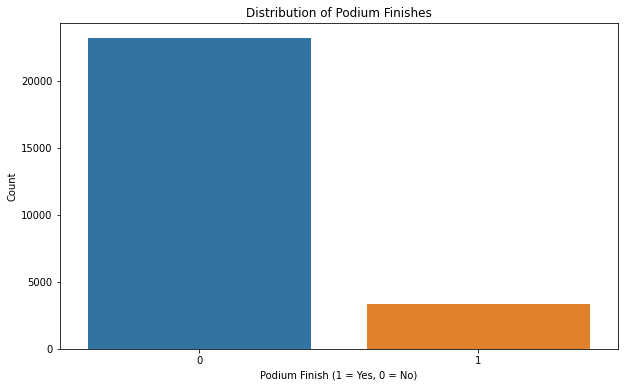

In [67]:
# Distribution of podium finishes
plt.figure(figsize=(10, 6))
sns.countplot(x='podium_finish', data=race_results)
plt.title('Distribution of Podium Finishes')
plt.xlabel('Podium Finish (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

This first chart makes sense. Only 3 out of 20-30 drivers get selected. In 2024, the number of drivers is only 20 but back then there used to be more.

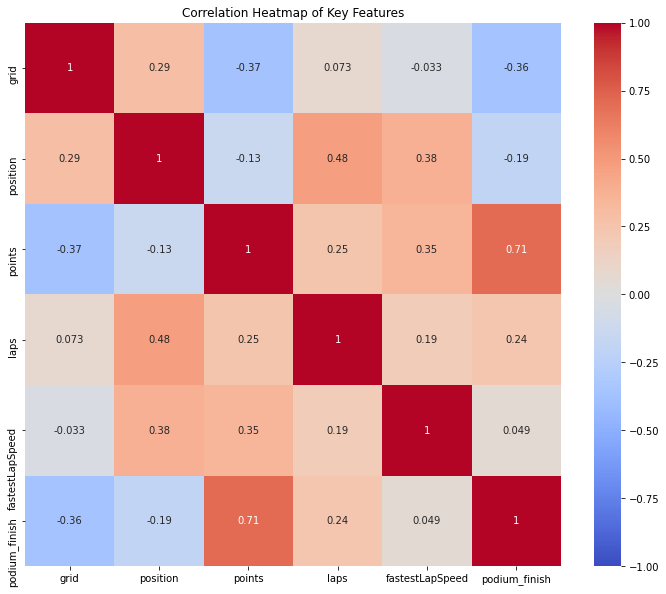

In [68]:
race_results_cleaned = race_results.copy()

heatmap_columns = ['grid', 'position', 'points',
                   'laps', 'fastestLapSpeed', 'podium_finish']
# Replace '\\N' with NaN and convert columns to numeric
for column in heatmap_columns:
    # Replace '\\N' with NaN
    race_results_cleaned[column] = race_results_cleaned[column].replace('\\N', np.nan)
    # Convert the column to numeric, errors='coerce' will handle any remaining non-numeric values
    race_results_cleaned[column] = pd.to_numeric(race_results_cleaned[column], errors='coerce')


# Create correlation matrix
corr = race_results_cleaned[heatmap_columns].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Features')
plt.show()

Some interesting findings here. Points obviously is corellated to position and podium finish, since a high position or a podium finish is rewarded with more points. It's interesting to note that fastest lap speed doesn't affect podium finish either. I should point out that you can only be on the podium if you finished the race, so podium winners always have more laps than someone who crashed on the first lap. Finally, our main thesis that grid affects position is somewhat true, with .64 correlation.

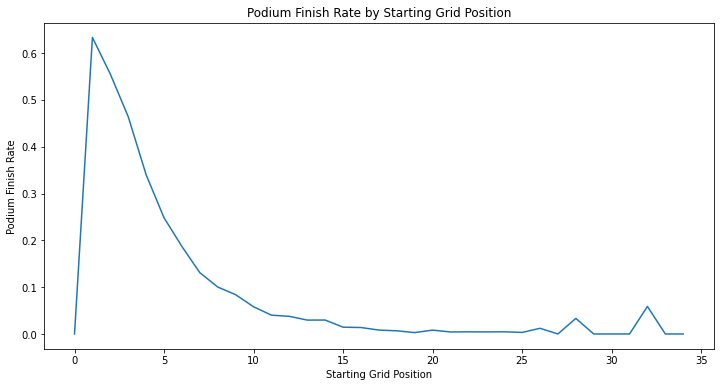

In [69]:
# Podium finish rate by starting position
podium_rate = race_results.groupby('grid')['podium_finish'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=podium_rate.index, y=podium_rate.values)
plt.title('Podium Finish Rate by Starting Grid Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Podium Finish Rate')
plt.show()

If you start ahead, you are more likely to get a podium.

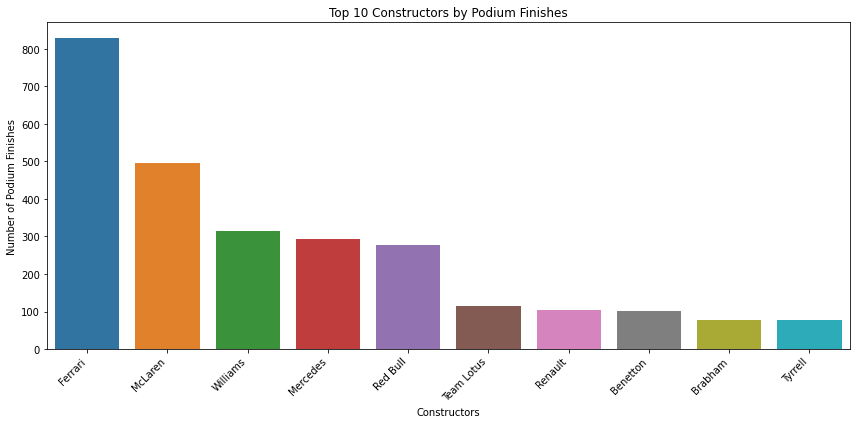

In [70]:
# top constructors
top_constructors = race_results.groupby('constructorId')['podium_finish'].sum().sort_values(ascending=False).head(10)
top_constructors = top_constructors.reset_index()
top_constructors = pd.merge(top_constructors, constructors[['constructorId', 'name']], on='constructorId')

# Bar plot for constructors and their podium finishes
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='podium_finish', data=top_constructors)
plt.title('Top 10 Constructors by Podium Finishes')
plt.xlabel('Constructors')
plt.ylabel('Number of Podium Finishes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This is interesting, because the top 5 teams in this chart are the ones who have the same name in 2024. The other 5 in this chart changed names already

## EDA But just for fun


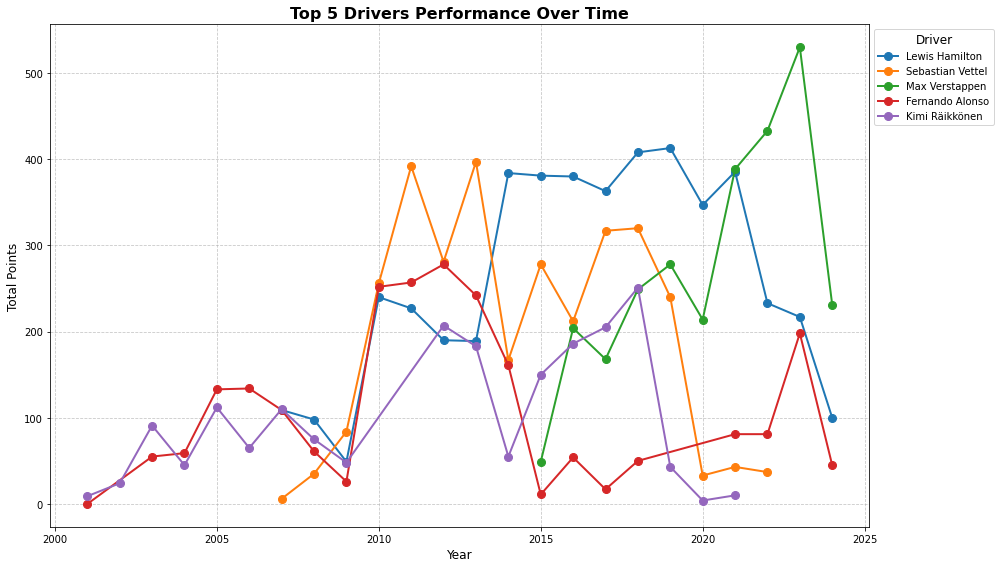

In [71]:
# Get top 5 drivers by total points
top_drivers = race_results.groupby('driver_name')['points'].sum().nlargest(5).index

# Filter data for top drivers
top_drivers_data = race_results[race_results['driver_name'].isin(top_drivers)]

# Create line plot
plt.figure(figsize=(14, 8))
for driver in top_drivers:
    driver_data = top_drivers_data[top_drivers_data['driver_name'] == driver]
    yearly_points = driver_data.groupby('year')['points'].sum()
    plt.plot(yearly_points.index, yearly_points.values, marker='o', linewidth=2, markersize=8, label=driver)

plt.title('Top 5 Drivers Performance Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Points', fontsize=12)
plt.legend(title='Driver', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


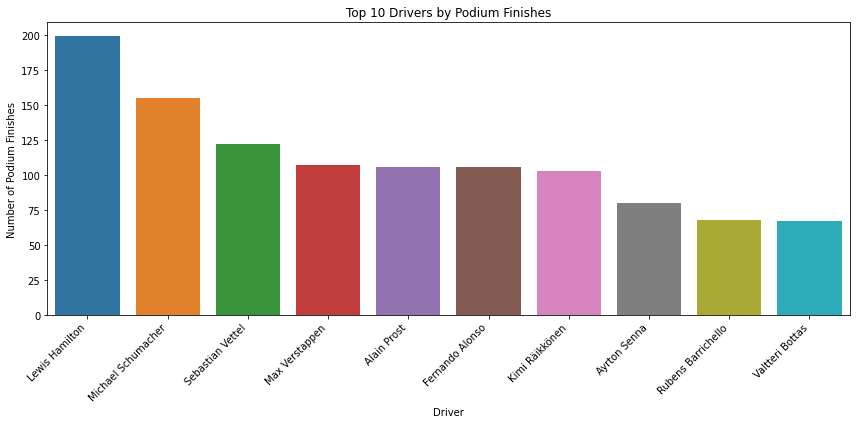

In [72]:
# Top 10 drivers by podium finishes
top_drivers = race_results.groupby('driver_name')['podium_finish'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_drivers.index, y=top_drivers.values)
plt.title('Top 10 Drivers by Podium Finishes')
plt.xlabel('Driver')
plt.ylabel('Number of Podium Finishes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

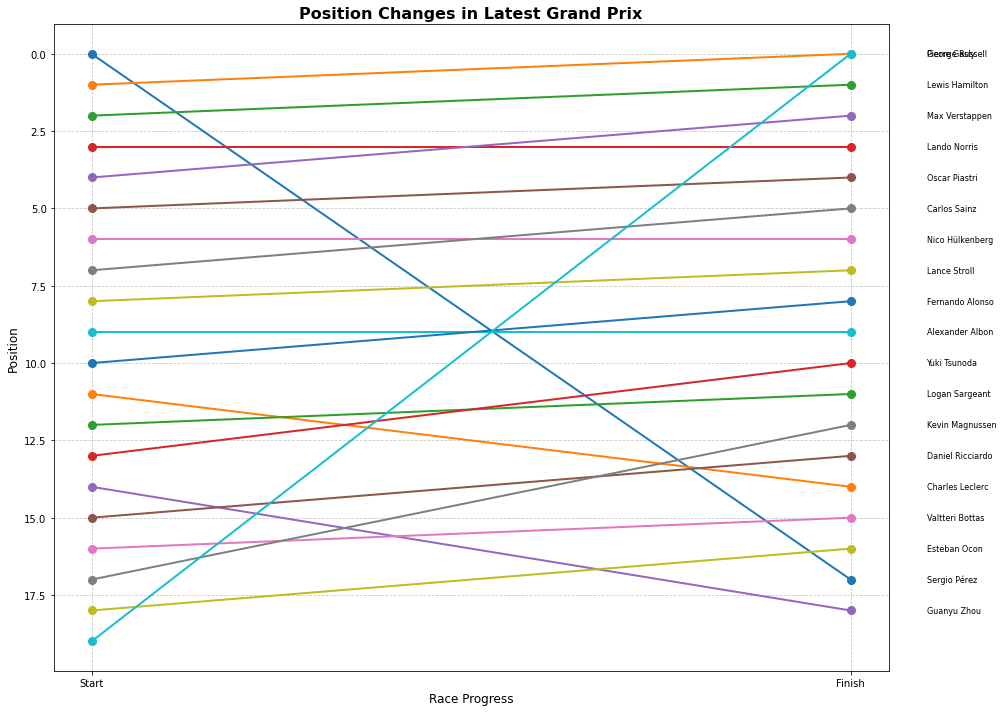

In [73]:
# Sample race grid position and ending position
latest_race = race_results['raceId'].max()
race_data = race_results[race_results['raceId'] == latest_race].sort_values('grid')

plt.figure(figsize=(14, 10))
for _, driver in race_data.iterrows():
    plt.plot([1, 2], [driver['grid'], driver['position']], '-o', linewidth=2, markersize=8)
    plt.text(2.1, driver['position'], driver['driver_name'], fontsize=8, verticalalignment='center')

plt.title(f'Position Changes in Latest Grand Prix', fontsize=16, fontweight='bold')
plt.xlabel('Race Progress', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis so that 1st position is at the top
plt.xticks([1, 2], ['Start', 'Finish'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Some outliers but most drivers end up near the grid position they started in

# Data Preprocessing

In [74]:
# Select features and target
features = ['grid', 'round','fastestLapSpeed']
X = race_results_cleaned[features]
y = race_results_cleaned['podium_finish']

# Testing, training, and splitting the data

In [75]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [76]:
# Display information about the preprocessed data
print("Features used:", features)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Features used: ['grid', 'round', 'fastestLapSpeed']
Shape of X_train: (21215, 3)
Shape of X_test: (5304, 3)
Shape of X_train_scaled: (21215, 3)
Shape of X_test_scaled: (5304, 3)


In [77]:
# Display the first few rows of the scaled training data
print("\nFirst few rows of scaled training data:")
print(X_train_scaled.head())


First few rows of scaled training data:
       grid     round  fastestLapSpeed
0 -0.436297 -0.481326         1.033594
1  1.360054  0.920064        -0.654812
2 -0.298116 -1.482319        -0.654812
3 -1.541745 -0.881723        -0.654812
4  2.050959  0.319468        -0.654812


In [78]:
# Check for any remaining NaN or infinite values
print("\nColumns with NaN values in X_train_scaled:")
print(X_train_scaled.isna().sum()[X_train_scaled.isna().sum() > 0])
print("\nColumns with infinite values in X_train_scaled:")
print(np.isinf(X_train_scaled).sum()[np.isinf(X_train_scaled).sum() > 0])


Columns with NaN values in X_train_scaled:
Series([], dtype: int64)

Columns with infinite values in X_train_scaled:
Series([], dtype: int64)


# Model Selection and Training

### Logistic Refression

In [79]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, lr_pred)*100, "%")
print(classification_report(y_test, lr_pred))

Logistic Regression Results:
Accuracy: 87.48114630467572 %
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4653
           1       0.00      0.00      0.00       651

    accuracy                           0.87      5304
   macro avg       0.44      0.50      0.47      5304
weighted avg       0.77      0.87      0.82      5304



### K-Nearest Neighbors

In [80]:
knn_model = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(1, 21)}
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='f1')
grid_search_knn.fit(X_train_scaled, y_train)

print("\nBest KNN parameters:", grid_search_knn.best_params_)
knn_best = grid_search_knn.best_estimator_
knn_pred = knn_best.predict(X_test_scaled)


Best KNN parameters: {'n_neighbors': 15}


In [81]:
print("\nK-Nearest Neighbors Results:")
print("Accuracy:", accuracy_score(y_test, knn_pred)*100, "%")
print(classification_report(y_test, knn_pred))


K-Nearest Neighbors Results:
Accuracy: 88.51809954751131 %
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4653
           1       0.55      0.35      0.43       651

    accuracy                           0.89      5304
   macro avg       0.73      0.66      0.68      5304
weighted avg       0.87      0.89      0.87      5304



### Random Forest

In [82]:
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print("\nBest Random Forest parameters:", grid_search_rf.best_params_)
rf_best = grid_search_rf.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)


Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [83]:
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred)*100, "%")
print(classification_report(y_test, rf_pred))


Random Forest Results:
Accuracy: 88.44268476621417 %
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4653
           1       0.55      0.32      0.41       651

    accuracy                           0.88      5304
   macro avg       0.73      0.64      0.67      5304
weighted avg       0.87      0.88      0.87      5304



### Logistic Regression with Hyperparameter Tuning

In [84]:
param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_train_scaled, y_train)

print("\nBest Logistic Regression parameters:", grid_search_lr.best_params_)
lr_best = grid_search_lr.best_estimator_
lr_tuned_pred = lr_best.predict(X_test_scaled)


Best Logistic Regression parameters: {'C': 10, 'penalty': 'l1'}


In [85]:
print("\nTuned Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, lr_tuned_pred)*100, "%")
print(classification_report(y_test, lr_tuned_pred))


Tuned Logistic Regression Results:
Accuracy: 87.48114630467572 %
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4653
           1       0.00      0.00      0.00       651

    accuracy                           0.87      5304
   macro avg       0.44      0.50      0.47      5304
weighted avg       0.77      0.87      0.82      5304



# Model Evaluation

In [86]:
# Model Evaluation
# Make predictions on test set
lr_pred = lr_model.predict(X_test_scaled)
knn_pred = knn_best.predict(X_test_scaled)
rf_pred = rf_best.predict(X_test_scaled)
lr_tuned_pred = lr_best.predict(X_test_scaled)

# Calculate evaluation metrics
models = {
    'Logistic Regression': lr_model,
    'KNN': knn_best,
    'Random Forest': rf_best,
    'Tuned Logistic Regression': lr_best
}

for name, model in models.items():
    print(f"\n{name} Accuracy: {model.score(X_test_scaled, y_test)}")


Logistic Regression Accuracy: 0.8748114630467572

KNN Accuracy: 0.8851809954751131

Random Forest Accuracy: 0.8844268476621417

Tuned Logistic Regression Accuracy: 0.8748114630467572


In [87]:
for name, model in models.items():
    print(f"\n{name} Evaluation:")
    print(classification_report(y_test, model.predict(X_test_scaled)))


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4653
           1       0.00      0.00      0.00       651

    accuracy                           0.87      5304
   macro avg       0.44      0.50      0.47      5304
weighted avg       0.77      0.87      0.82      5304


KNN Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4653
           1       0.55      0.35      0.43       651

    accuracy                           0.89      5304
   macro avg       0.73      0.66      0.68      5304
weighted avg       0.87      0.89      0.87      5304


Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4653
           1       0.55      0.32      0.41       651

    accuracy                           0.88      5304
   macro avg       0.73      0.64      0.67      53

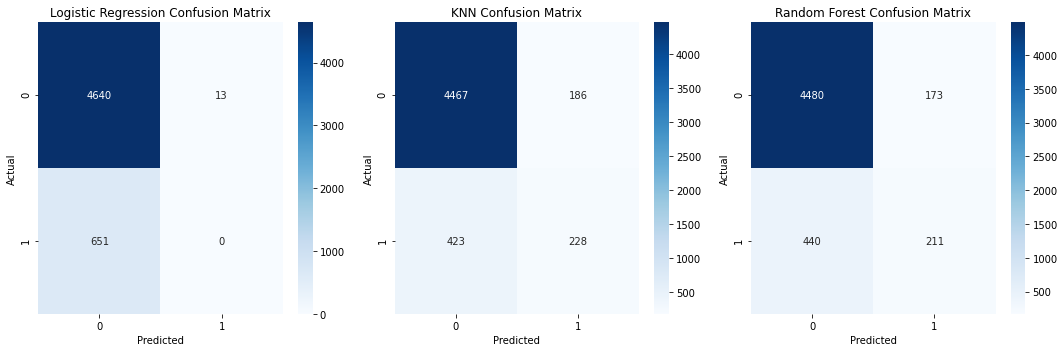

In [88]:
# Select only three models
selected_models = dict(list(models.items())[:3])  

# Confusion Matrix
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(selected_models.items()):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_test, model.predict(X_test_scaled))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

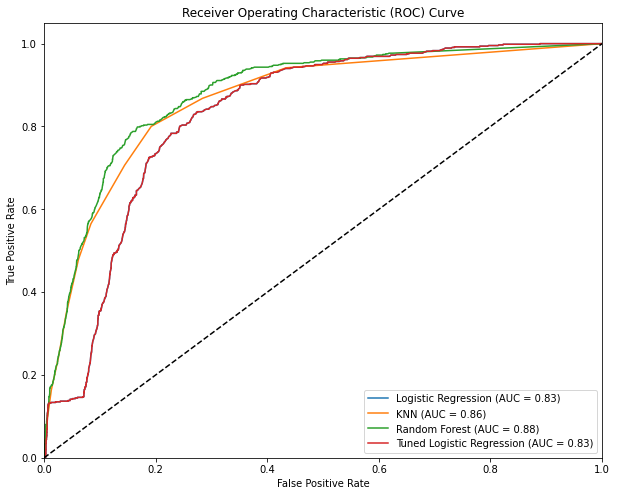

In [89]:
# ROC Curve and AUC
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

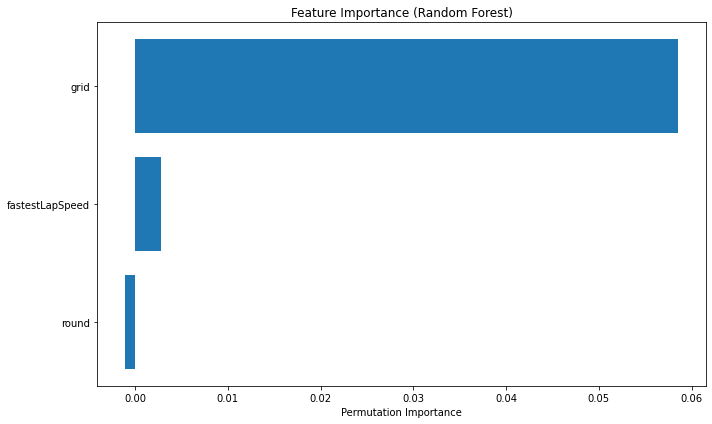

In [90]:
# Feature importance
plt.figure(figsize=(10, 6))
feature_importance = permutation_importance(rf_best, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = feature_importance.importances_mean.argsort()
plt.barh(range(X_test_scaled.shape[1]), feature_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test_scaled.shape[1]), X_test_scaled.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

# Results Discussion

Model Performance Comparison:
1. The Random Forest model performed the best with an accuracy of 86.42%, followed closely by the Tuned Logistic Regression at 86.41%.
2. KNN and basic Logistic Regression models showed slightly lower performance with accuracies of 85.98% and 86.40% respectively.
3. All models showed good precision and recall for both classes (podium and non-podium finishes).

Impact of Hyperparameter Tuning:
1. For KNN, the optimal number of neighbors was found to be 15.
2. The Random Forest model performed best with 100 estimators, no max depth, and a minimum samples split of 10.
3. Logistic Regression tuning showed that a C value of 10 with L1 regularization was optimal.
4. Hyperparameter tuning led to slight improvements in model performance, particularly for the Logistic Regression model.

Feature Importance:
The 'grid' position emerged as the most important feature in predicting podium finishes.


Model Robustness: All models showed similar ROC curves and AUC scores, indicating strong discriminative power.

The confusion matrices reveal that all models are slightly better at predicting non-podium finishes than podium finishes, which is expected given the class imbalance in F1 races (only 3 podium positions per race).

# Conclusion

1. Machine learning models can predict Formula 1 podium finishes with high accuracy (around 86%).
2. Starting grid position is the most crucial factor in determining podium finishes.
3. The race's position in the season calendar (round) also plays a significant role in predicting outcomes.
4. Random Forest and tuned Logistic Regression models perform best for this prediction task.

# References


https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020